In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as  plt
%matplotlib inline

In [3]:
import os

In [4]:
import torch 
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [5]:
from torch import nn, optim
import torch.nn.functional as F

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
os.listdir('face-images-with-marked-landmark-points/')

['face_images.npy', 'facial_keypoints.csv', 'face_images.npz']

In [8]:
# Modify the path 
root = 'face-images-with-marked-landmark-points/'

In [9]:
# load the dataset
face_images_db = np.load(root+'face_images.npz')['face_images']
facial_keypoints_df = pd.read_csv(root+'facial_keypoints.csv')

In [19]:
facial_keypoints_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166
5,69.680748,39.968748,29.183551,37.563364,62.864299,40.169271,76.898243,41.171888,36.401047,39.367626,...,52.468486,58.800000,64.869084,82.471178,31.990430,81.669084,49.308112,78.487626,49.432374,93.898766
6,64.131866,34.290040,29.578953,33.138040,57.797154,35.154040,69.026577,34.290040,34.761664,33.714040,...,46.855087,53.006174,55.781799,70.570953,33.898309,70.282953,45.127732,65.099597,45.415732,78.057020
7,67.468893,39.413452,29.355961,39.621717,59.554951,40.454773,75.591612,40.038245,37.478214,40.454773,...,47.891883,56.907961,66.843961,80.025786,30.189204,81.275184,48.100194,71.278602,48.516816,91.063922
8,65.802880,34.755200,27.475840,36.185600,58.652160,37.329280,72.952960,35.899520,36.342400,37.043200,...,48.069760,55.348480,65.516800,73.368320,31.194240,74.798080,49.213440,67.648000,49.499520,83.093120
9,64.121231,36.740308,29.468923,38.390154,58.620923,37.840615,71.272000,37.290338,36.344615,39.490462,...,48.995077,54.341538,65.771692,69.192615,32.769231,72.217846,49.270154,67.542769,49.545231,76.893538


In [22]:
facial_keypoints_df.isnull().sum(axis=1)

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
7019    22
7020    22
7021    22
7022    22
7023    22
7024    22
7025    22
7026    22
7027    22
7028    22
7029    22
7030    22
7031    22
7032    22
7033    22
7034    22
7035    22
7036    22
7037    22
7038    22
7039    22
7040    22
7041    22
7042    22
7043    22
7044    22
7045    22
7046    22
7047    22
7048    22
Length: 7049, dtype: int64

In [16]:
numMissingKeypoints = facial_keypoints_df.isnull().sum(axis=1)

In [20]:
(numMissingKeypoints == 0)[0]

True

In [24]:
np.nonzero(numMissingKeypoints == 0)[0]           # selecting the indices with all the 15 keypoints. No missing points.

array([   0,    1,    2, ..., 2281, 2282, 2283])

In [25]:
# np.nonzero returns the indices of the elements that are non-zero.
allKeypointsPresentInds = np.nonzero(numMissingKeypoints == 0)[0]

In [26]:
faceImagesDB = face_images_db[:,:,allKeypointsPresentInds]
facialKeypointsDF = facial_keypoints_df.iloc[allKeypointsPresentInds,:].reset_index(drop=True)

(imHeight, imWidth, numImages) = faceImagesDB.shape
numKeypoints = facialKeypointsDF.shape[1] / 2

print('number of remaining images = %d' %(numImages))
print('image dimentions = (%d,%d)' %(imHeight,imWidth))
print('number of facial keypoints = %d' %(numKeypoints))

number of remaining images = 2140
image dimentions = (96,96)
number of facial keypoints = 15


In [29]:
faceImagesDB.shape

(96, 96, 2140)

In [30]:
facial_keypoints_df.shape

(7049, 30)

In [31]:
(im_height, im_width, num_images) = face_images_db.shape
num_keypoints = facial_keypoints_df.shape[1] / 2

In [32]:
facial_keypoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [33]:
print('number of images = %d' %(num_images))
print('image dimentions = (%d,%d)' %(im_height,im_width))
print('number of facial keypoints = %d' %(num_keypoints))

number of images = 7049
image dimentions = (96,96)
number of facial keypoints = 15


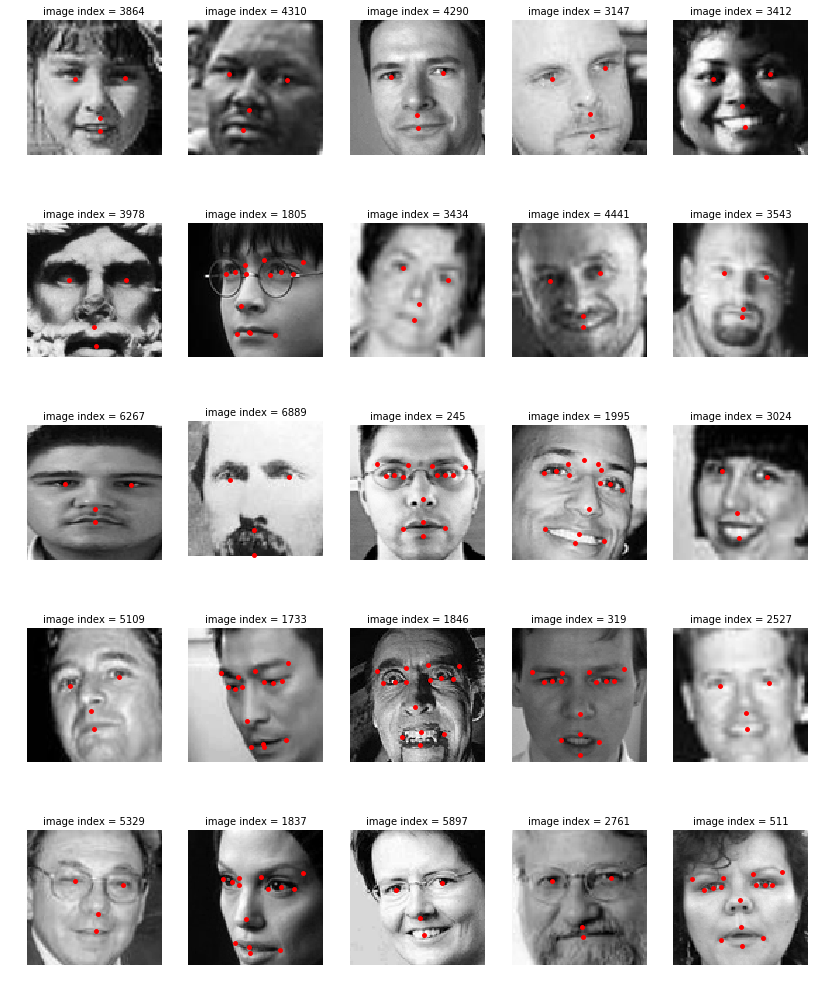

In [34]:
# show a random subset of images from the dataset

num_fig_rows = 5
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

rand_inds_vec = np.random.choice(face_images_db.shape[2],num_plots,replace=False)  # choose random image landmarks
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

plt.close('all')
fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,18))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = face_images_db[:,:,curr_ind]
    
        x_feature_coords = np.array(facial_keypoints_df.iloc[curr_ind,0::2].tolist())
        y_feature_coords = np.array(facial_keypoints_df.iloc[curr_ind,1::2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=15)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)


In [35]:
facial_keypoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [36]:
facial_keypoints_df.iloc[0,0::2]            # getting the x-coodinates (even indices)

left_eye_center_x            66.033564
right_eye_center_x           30.227008
left_eye_inner_corner_x      59.582075
left_eye_outer_corner_x      73.130346
right_eye_inner_corner_x     36.356571
right_eye_outer_corner_x     23.452872
left_eyebrow_inner_end_x     56.953263
left_eyebrow_outer_end_x     80.227128
right_eyebrow_inner_end_x    40.227609
right_eyebrow_outer_end_x    16.356379
nose_tip_x                   44.420571
mouth_left_corner_x          61.195308
mouth_right_corner_x         28.614496
mouth_center_top_lip_x       43.312602
mouth_center_bottom_lip_x    43.130707
Name: 0, dtype: float64

In [37]:
facial_keypoints_df.iloc[0,1::2]             # getting the y-coordinates (odd indices)

left_eye_center_y            39.002274
right_eye_center_y           36.421678
left_eye_inner_corner_y      39.647423
left_eye_outer_corner_y      39.969997
right_eye_inner_corner_y     37.389402
right_eye_outer_corner_y     37.389402
left_eyebrow_inner_end_y     29.033648
left_eyebrow_outer_end_y     32.228138
right_eyebrow_inner_end_y    29.002322
right_eyebrow_outer_end_y    29.647471
nose_tip_y                   57.066803
mouth_left_corner_y          79.970165
mouth_right_corner_y         77.388992
mouth_center_top_lip_y       72.935459
mouth_center_bottom_lip_y    84.485774
Name: 0, dtype: float64

In [38]:
np.array(facial_keypoints_df.iloc[1000,0::2].tolist())

array([ 66.97936842,  30.85052632,  62.08673684,  72.24842105,
        36.87157895,  25.95789474,  58.69978947,  79.77515789,
        40.25852632,  16.17263158,  50.10863158,  65.09726316,
        38.00084211,  49.29094737,  50.42021053])

In [39]:
facial_keypoints_df.iloc[1000,:]

left_eye_center_x            66.979368
left_eye_center_y            33.665011
right_eye_center_x           30.850526
right_eye_center_y           34.794105
left_eye_inner_corner_x      62.086737
left_eye_inner_corner_y      34.794105
left_eye_outer_corner_x      72.248421
left_eye_outer_corner_y      35.170442
right_eye_inner_corner_x     36.871579
right_eye_inner_corner_y     35.546779
right_eye_outer_corner_x     25.957895
right_eye_outer_corner_y     37.052126
left_eyebrow_inner_end_x     58.699789
left_eyebrow_inner_end_y     21.998400
left_eyebrow_outer_end_x     79.775158
left_eyebrow_outer_end_y     25.009179
right_eyebrow_inner_end_x    40.258526
right_eyebrow_inner_end_y    22.751074
right_eyebrow_outer_end_x    16.172632
right_eyebrow_outer_end_y    29.525305
nose_tip_x                   50.108632
nose_tip_y                   48.452211
mouth_left_corner_x          65.097263
mouth_left_corner_y          70.546526
mouth_right_corner_x         38.000842
mouth_right_corner_y     

In [40]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, main_dir, transform=None):
        
        #self.face_images_db = np.load(main_dir+'/face_images.npz')['face_images']
        #self.facial_keypoints_df = pd.read_csv(main_dir+'/facial_keypoints.csv')
        self.face_images_db = faceImagesDB
        self.facial_keypoints_df = facialKeypointsDF
        self.transform = transform

    def __len__(self):
        return len(self.facial_keypoints_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.face_images_db[:,:,idx].astype('float32')
        landmarks = self.facial_keypoints_df.iloc[idx,:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float')
        
        if self.transform:
            img = self.transform(img)
        
        sample = {'image': img, 'landmarks': landmarks}
        return sample

In [41]:
# Don't use this transform directly
data_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(90),
                                     transforms.RandomCrop(40),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))
                                     ])

In [ ]:
data_trans= transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                     ])

In [42]:
valid_ratio = 0.1
face_dataset = FaceLandmarksDataset(main_dir=root,transform=data_trans)

num_train = len(face_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_ratio*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Data samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(face_dataset, sampler=train_sampler, batch_size=10, shuffle=False)
validloader = torch.utils.data.DataLoader(face_dataset, sampler=valid_sampler, batch_size=10, shuffle=False)

In [44]:
len(trainloader)

193

In [45]:
facial_keypoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [46]:
def face_viz_with_landmarks(n = 4):
    ncol = 4
    nrows = np.ceil(n/ncol)
    fig = plt.figure(figsize=(20,ncol))
    for i in range(len(face_dataset)):
        sample = face_dataset[i]
        #print(np.transpose(sample['image'],(1,2,0)).shape)
        #print(i, sample['image'].shape, sample['landmarks'].shape)

        x_cord = sample['landmarks'][0][0::2]
        y_cord = sample['landmarks'][0][1::2]
        
        
        ax = plt.subplot(nrows, ncol, i + 1)
        ax.imshow(np.transpose(sample['image'],(1,2,0)).squeeze())
        ax.scatter(x_cord,y_cord,c='r',s=8)
        #plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        if i == n-1:
            plt.show()
            break

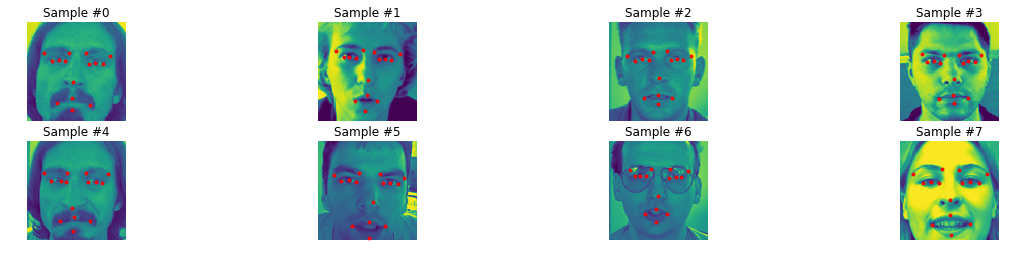

In [47]:
face_viz_with_landmarks(8)

In [57]:
dataiter = iter(trainloader)
sample = dataiter.next()

In [58]:
sample['image'].size()

torch.Size([10, 1, 96, 96])

In [60]:
sample['landmarks']        # With all 15 keypoints. No NAN values

tensor([[[64.7145, 42.0456, 28.1263, 43.3183, 59.3057, 42.6819, 72.0321,
          42.6819, 35.1255, 43.6364, 22.0810, 43.9544, 53.8968, 32.1827,
          81.5770, 34.0915, 40.2163, 32.1827, 12.8546, 36.0007, 46.2612,
          62.4077, 63.7601, 82.1334, 32.2623, 82.7698, 47.2156, 75.4522,
          48.4884, 87.5422]],

        [[65.5774, 38.1112, 27.9494, 40.2216, 59.5995, 38.4630, 74.0176,
          38.1112, 33.9281, 39.8699, 21.2679, 40.9251, 56.7864, 30.0236,
          80.3481, 31.0780, 37.4447, 32.4850, 18.4548, 33.1885, 46.5875,
          50.4197, 63.1161, 76.4428, 36.7412, 77.8497, 49.0497, 68.7061,
          50.1041, 82.4215]],

        [[65.9455, 39.3437, 31.7684, 37.1623, 59.6431, 39.3437, 72.7322,
          40.7978, 37.8283, 38.6164, 24.9817, 36.9199, 56.3607, 29.5289,
          80.0043, 32.5565, 42.6793, 27.7863, 15.7706, 28.6785, 48.2511,
          57.7654, 61.0978, 80.3075, 29.3445, 77.8837, 45.6331, 75.4289,
          45.7155, 84.1633]],

        [[66.8114, 37.0497, 28.

In [50]:
key_pts = sample['landmarks'].view(sample['landmarks'].size(0), -1)

In [51]:
type(key_pts)

torch.Tensor

In [52]:
#sample['landmarks'][0][0][0::2]

In [53]:
#plt.imshow(sample['image'][1][0])

torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])
torch.Size([10, 1, 96, 96])


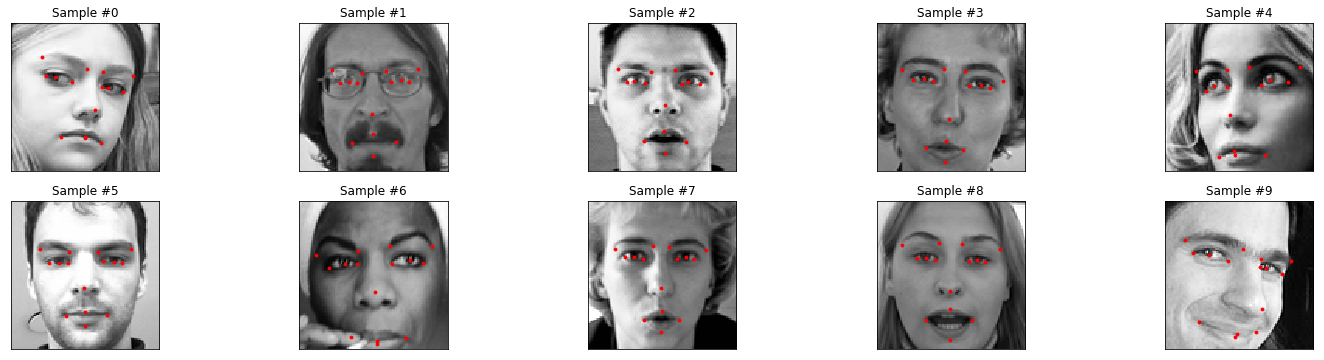

In [54]:
# Plotting from the trainloader
fig = plt.figure(figsize=(25,6))
for idx in range(10):
    
    x_cord = sample['landmarks'][idx][0][0::2]
    y_cord = sample['landmarks'][idx][0][1::2]
    
    print(sample['image'].shape)
    ax = fig.add_subplot(2,10/2,idx+1,xticks=[],yticks=[])
    ax.imshow(sample['image'][idx][0],cmap='gray')
    ax.scatter(x_cord,y_cord,c='r',s=8)
    # .item() gets the value contained in a Tensor
    ax.set_title('Sample #{}'.format(idx))

In [55]:
class Landmarks(nn.Module):
    def __init__(self):
        super(Landmarks, self).__init__()
        
        self.conv1 = nn.Conv2d(1,32,kernel_size=5,padding=2,stride=1)         # 80 * 80 -- 80 * 80 * 32
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1)        # 80 * 80 * 32  --> 80 * 80 * 64  --> 40 * 40 * 64
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1)       # 40 * 40 * 64  --> 38 * 38 * 128
        self.conv4 = nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1)      # 40 * 40 * 128 --> 36 * 36 * 256 --> 18 * 18 * 256
        self.conv5 = nn.Conv2d(256,512,kernel_size=1)          # 18 * 18 * 256 --> 18 * 18 * 512 --> 9 * 9 *512
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(512*12*12,2048)
        self.fc2 = nn.Linear(2048,512)
        self.fc3 = nn.Linear(512,30)
        self.dropout = nn.Dropout(p=0.4)
    
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1,512*12*12)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [42]:
input1 = Variable(torch.ones(1,1,5,5))
print(input1.shape)
x = torch.nn.Conv2d(in_channels = 1, out_channels = 1
                    , kernel_size = 1)
out = x(input1)
print(out.shape)
#print(list(x.parameters()))

torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 5, 5])


In [43]:
model = Landmarks()

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# Modify the PATH for saving your models.

epochs = 20
train_losses = []
valid_losses = []
valid_loss_min = 0.07             # Change this to put a threshold for saving models.
accuracy_list = []

for e in range(epochs):
    print('Starting epoch:',e)
    batch_loss = 0
    valid_loss = 0
    for samples in trainloader:
        image, landmarks = samples['image'], samples['landmarks']
        
        key_pts = landmarks.view(landmarks.size(0), -1)
        
        key_pts = key_pts.type(torch.FloatTensor)
        image = image.type(torch.FloatTensor)
        keypoints_out = model(image)
        
        loss = criterion(keypoints_out,key_pts)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
    with torch.no_grad():
        model.eval()
        for samples in validloader:
            image, landmarks = samples['image'], samples['landmarks']
            key_pts = landmarks.view(landmarks.size(0), -1)
            
            key_pts = key_pts.type(torch.FloatTensor)
            image = images.type(torch.FloatTensor)
            
            keypoints_out = model(image)
            loss = criterion(keypoints_out,key_pts)
            
            valid_loss +=loss.item()
            
            #equals = classes == labels.view(*classes.shape)
            #accuracy = torch.mean(equals.type(torch.FloatTensor))
            
    train_losses.append(batch_loss/len(trainloader))
    valid_losses.append(valid_loss/len(validloader))
    print(f"Training loss: {batch_loss/len(trainloader)}, Validation loss: {valid_loss/len(validloader)}")
    
    #print(f"Accuracy (Validation): {accuracy.item()*100}%")
    #accuracy_list.append(accuracy.item())
    if (valid_loss/len(validloader)) <= valid_loss_min:
        print(f"Validation loss decreased from {valid_loss_min} to {valid_loss/len(validloader)}. Saving the model")
        valid_loss_min = valid_loss/len(validloader)
        torch.save(model,'PATH/model_'+str(e)+'_loss'+str(valid_loss/len(validloader))+'.pth')
    model.train()

Starting epoch: 0
torch.Size([10, 32, 96, 96])
